In [8]:
sentences = [
    "Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
    "Xiaobing is Student", "Xiaoxue is Student"
]
words = " ".join(sentences).split()
word_list = list(set(words))
word_to_idx = {w: i for i, w in enumerate(word_list)}
idx_to_word = {i: w for i, w in enumerate(word_list)}
voc_size = len(word_list)
print(f"词汇表: {word_list}")
print(f"词汇到索引: {word_to_idx}")
print(f"索引到词汇: {idx_to_word}")
print(f"词汇表大小: {voc_size}")

词汇表: ['Kage', 'Xiaobing', 'Teacher', 'Niuzong', 'Xiaoxue', 'Student', 'Mazong', 'Boss', 'is']
词汇到索引: {'Kage': 0, 'Xiaobing': 1, 'Teacher': 2, 'Niuzong': 3, 'Xiaoxue': 4, 'Student': 5, 'Mazong': 6, 'Boss': 7, 'is': 8}
索引到词汇: {0: 'Kage', 1: 'Xiaobing', 2: 'Teacher', 3: 'Niuzong', 4: 'Xiaoxue', 5: 'Student', 6: 'Mazong', 7: 'Boss', 8: 'is'}
词汇表大小: 9


In [9]:
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx - window_size, 0): min(idx + window_size, len(sentence))]:
                if neighbor != word:
                    data.append((neighbor, word))
    return data

In [13]:
skipgram_data = create_skipgram_dataset(sentences)
print(f"SkipGram 数据集: {skipgram_data[:3]}")

SkipGram 数据集: [('is', 'Kage'), ('Kage', 'is'), ('Teacher', 'is')]


In [12]:
import torch

def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor

word_sample = "Teacher"
print(f"编码前单词: {word_sample}")
print(f"Onehot 编码: {one_hot_encoding(word_sample, word_to_idx)}")
print(f"SkipGram 数据样例: {[(one_hot_encoding(context, word_to_idx), word_to_idx[target]) for context, target in skipgram_data[:3]]}")

编码前单词: Teacher
Onehot 编码: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.])
SkipGram 数据样例: [(tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 0), (tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 8), (tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]), 8)]


In [15]:
import torch.nn as nn

class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)
    
    def forward(self, X):
        hidden = self.input_to_hidden(X)
        output = self.hidden_to_output(hidden)
        return output
    

In [16]:
embedding_size = 2
skipgram_model = SkipGram(voc_size, embedding_size)
print(skipgram_model)

SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


In [19]:
import torch.optim as optim

learning_rate = 0.001
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)
loss_values = []
for epoch in range(epochs):
    loss_sum = 0
    for context, target in skipgram_data:
        X = one_hot_encoding(target, word_to_idx).float().unsqueeze(0)
        y_true= torch.tensor([word_to_idx[context]], dtype=torch.long)
        y_pred = skipgram_model(X)
        loss = criterion(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch:{epoch+1}, Loss:{loss_sum/len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))




Epoch:100, Loss:2.1805975961685182
Epoch:200, Loss:2.151264452934265
Epoch:300, Loss:2.1102455854415894
Epoch:400, Loss:2.04721086025238
Epoch:500, Loss:1.9546745252609252
Epoch:600, Loss:1.8410487580299377
Epoch:700, Loss:1.7350003623962402
Epoch:800, Loss:1.6558413088321686
Epoch:900, Loss:1.6006212556362152
Epoch:1000, Loss:1.5612042433023452


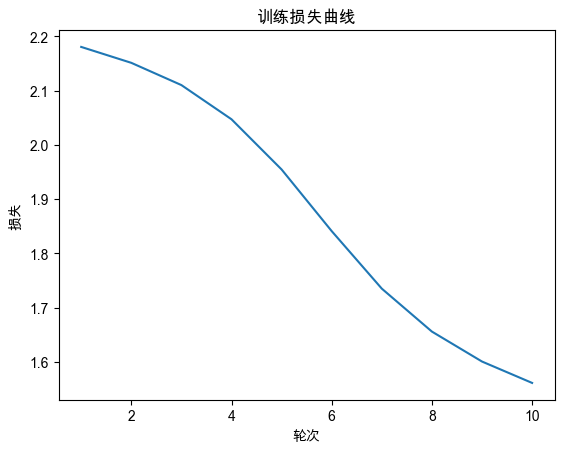

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["Arial Unicode MS"]
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

plt.plot(range(1, epochs//100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("轮次")
plt.ylabel("损失")
plt.show()